In [27]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [28]:
# Copyright (c) OpenMMLab. All rights reserved.
import os
from argparse import ArgumentParser
from pathlib import Path

import mmcv
from mmdet.apis import inference_detector, init_detector
from mmengine.config import Config, ConfigDict
from mmengine.logging import print_log
from mmengine.utils import ProgressBar, path

from mmyolo.registry import VISUALIZERS
from mmyolo.utils import switch_to_deploy
from mmyolo.utils.labelme_utils import LabelmeFormat
from mmyolo.utils.misc import get_file_list, show_data_classes


In [31]:
config = "./mmyolo/work_dir/ppy/refine_v2/mymodel_refine.py"
checkpoint = "./mmyolo/work_dir/ppy/refine_v2/best_coco_bbox_mAP_epoch_95.pth"
tta_flag=True
device = 'cuda:0'
out_dir = "./mmyolo/out_dir"
score_thr = 0.3

In [32]:
config = Config.fromfile(config)
if 'init_cfg' in config.model.backbone:
    config.model.backbone.init_cfg = None

In [33]:
if tta_flag:
    assert 'tta_model' in config, 'Cannot find ``tta_model`` in config.' \
        " Can't use tta !"
    assert 'tta_pipeline' in config, 'Cannot find ``tta_pipeline`` ' \
        "in config. Can't use tta !"
    config.model = ConfigDict(**config.tta_model, module=config.model)
    test_data_cfg = config.test_dataloader.dataset
    while 'dataset' in test_data_cfg:
        test_data_cfg = test_data_cfg['dataset']

    # batch_shapes_cfg will force control the size of the output image,
    # it is not compatible with tta.
    if 'batch_shapes_cfg' in test_data_cfg:
        test_data_cfg.batch_shapes_cfg = None
    test_data_cfg.pipeline = config.tta_pipeline

In [34]:
model = init_detector(config, checkpoint, device=device, cfg_options={})
switch_to_deploy(model)
path.mkdir_or_exist(out_dir)

Loads checkpoint by local backend from path: ./mmyolo/work_dir/ppy/refine_v2/best_coco_bbox_mAP_epoch_95.pth
Switch model to deploy modality.


In [35]:
visualizer = VISUALIZERS.build(model.cfg.visualizer)
visualizer.dataset_meta = model.dataset_meta

/opt/conda/lib/python3.7/site-packages/mmengine/utils/manager.py:114: UserWarning: <class 'mmdet.visualization.local_visualizer.DetLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  f'{cls} instance named of {name} has been created, '


In [36]:
###test
file = "./mmyolo/demo/demo.jpg"

In [37]:
result = inference_detector(model, file)

img = mmcv.imread(file)
img = mmcv.imconvert(img, "bgr", "rgb")

filename = os.path.basename(file)
out_file = os.path.join(out_dir, filename)

# progress_bar.update()

# Get candidate predict info with score threshold
pred_instances = result.pred_instances[
    result.pred_instances.scores > score_thr
]


visualizer.add_datasample(
    filename,
    img,
    data_sample=result,
    draw_gt=False,
    show=False,
    wait_time=0,
    out_file=out_file,
    pred_score_thr=score_thr,
)

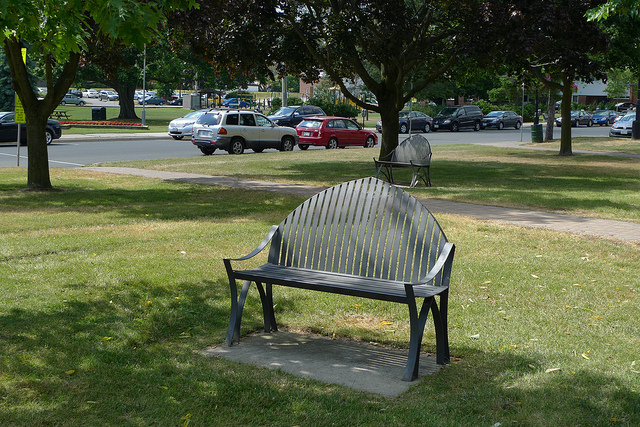

In [38]:
from PIL import Image
Image.open('./mmyolo/demo/demo.jpg')

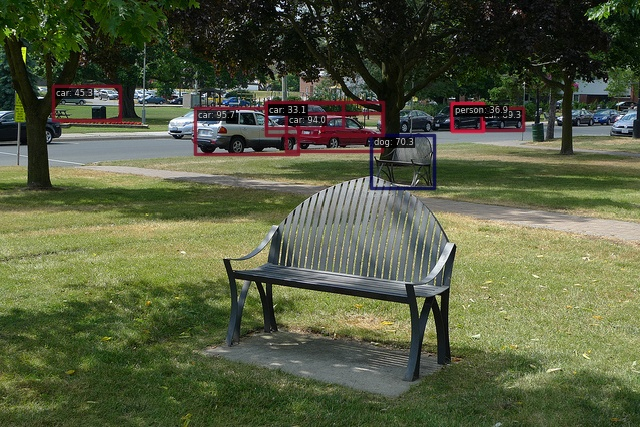

In [39]:
from PIL import Image
Image.open('./mmyolo/out_dir/demo.jpg')

In [40]:
file = './mmyolo/data/all_dataset/test/test_open_85.png'


In [41]:
result = inference_detector(model, file)

img = mmcv.imread(file)
img = mmcv.imconvert(img, "bgr", "rgb")

filename = os.path.basename(file)
out_file = os.path.join(out_dir, filename)

# progress_bar.update()

# Get candidate predict info with score threshold
pred_instances = result.pred_instances[
    result.pred_instances.scores > score_thr
]


visualizer.add_datasample(
    filename,
    img,
    data_sample=result,
    draw_gt=False,
    show=False,
    wait_time=0,
    out_file=out_file,
    pred_score_thr=score_thr,
)

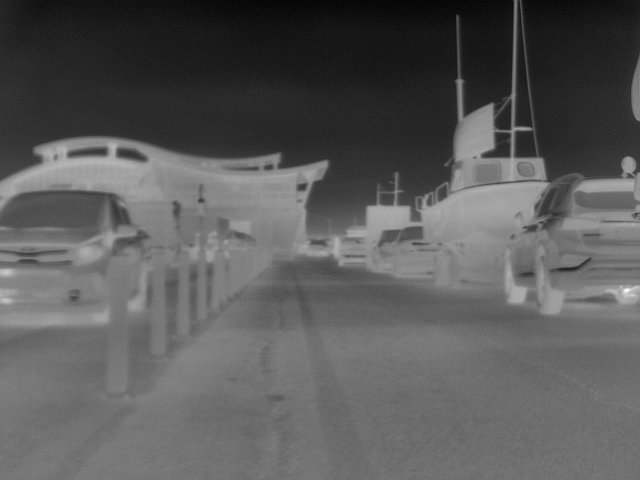

In [42]:
from PIL import Image
Image.open(file)

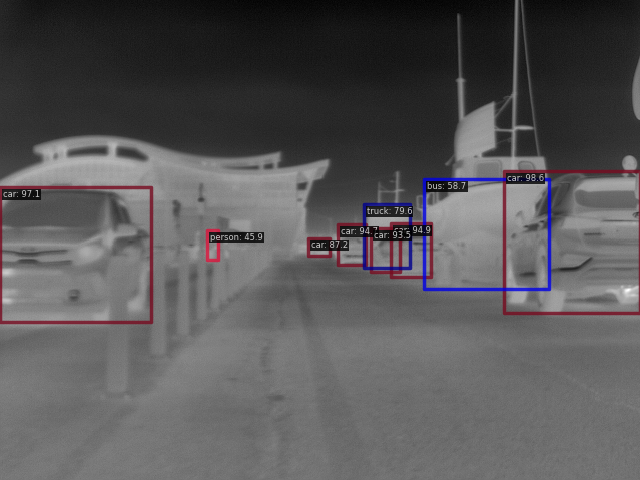

In [43]:
from PIL import Image
Image.open("mmyolo/out_dir/"+file.split("/")[-1])

In [44]:
from natsort import natsorted

test_dir_prefix = "mmyolo/data/all_dataset/test/"
images = os.listdir(test_dir_prefix)
sorted_images = natsorted(images)


# result = inference_detector(model, file)


In [45]:
# bboxes = result.get("pred_instances").get("bboxes").tolist()
# len(bboxes)
# result.get("pred_instances").get("scores")
# result.get("pred_instances").get("labels")

In [ ]:
import json
sub_results = []
# total_num = 0
for image_dir in sorted_images:
    result = inference_detector(model, os.path.join(test_dir_prefix,image_dir))
    bboxes = result.get("pred_instances").get("bboxes").tolist()
    scores = result.get("pred_instances").get("scores").tolist()
    labels = result.get("pred_instances").get("labels").tolist()
    obj_num = len(bboxes)
    for idx in range(obj_num):
        if labels[idx] > 8:
            print(result['predictions'][0]["labels"][idx])
        min_x, min_y, max_x, max_y = bboxes[idx]
        ret = {
            "image_id" : str(image_dir.split(".")[0]),
            "category_id" : labels[idx],
            "bbox":[
                min_x,
                min_y,
                max_x-min_x,
                max_y-min_y
            ],
            "score":scores[idx],
        }

        sub_results.append(ret)
#     total_num+=1
#     print(total_num)
with open("/home/eslim/workspace/comp/results/sub_results_ppy_refine_tta.txt", "w") as file:
    json.dump(sub_results, file, indent=4)



In [19]:
# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="unauthorized")
# project = rf.workspace("nii").project("pedestrian-cvc-14")
# version = project.version(1)
# dataset = version.download("coco-mmdetection")
                

